In [9]:
# E91 Quantum Key Distribution Simulator
# Comprehensive simulation framework for E91 protocol over different channel types

# ========================== Import Libraries ==========================
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi, sqrt, log2, exp
from enum import Enum
from typing import Tuple, Dict, List, Optional
import warnings
warnings.filterwarnings('ignore')

class PhotonSource:
    def __init__(self, mu):
        self.mu = mu

    def photon_distribution(self, n_max=20):
        n_values = np.arange(n_max + 1)
        p_s = (n_values + 1) * ((self.mu / 2) ** n_values) / ((1 + (self.mu / 2)) ** (n_values + 2))
        return p_s

# ========================== Channel Class ==========================
class ChannelType(Enum):
    FIBER = "fiber"
    FSO = "fso"


class QuantumChannel:
    """
    Hybrid QuantumChannel with both user-defined flexibility and advanced FSO physics modeling.
    """

    def __init__(self, channel_type: ChannelType, **kwargs):
        self.channel_type = channel_type
        self._set_channel_parameters(**kwargs)

    def _set_channel_parameters(self, **kwargs):
        """Initialize and override default parameters."""
        self.alpha_db = kwargs.get('alpha_db', 0.2 if self.channel_type == ChannelType.FIBER else 0.1)
        self.max_distance = kwargs.get('max_distance', 300 if self.channel_type == ChannelType.FIBER else 50)
        self.alpha_linear = self.alpha_db / 4.343

        if self.channel_type == ChannelType.FIBER:
            self.noise_components = {
                'raman': kwargs.get('raman', 5e-5),
                'dark': kwargs.get('dark', 5e-6)
            }

        elif self.channel_type == ChannelType.FSO:
            # Optics and propagation
            self.tx_aperture = kwargs.get('tx_aperture', 0.01)
            self.rx_aperture = kwargs.get('rx_aperture', 0.03)
            self.beam_divergence = kwargs.get('beam_divergence', 0.001)  # radians
            self.wavelength = kwargs.get('wavelength', 850e-9)  # meters

            # Pointing error and turbulence
            self.pointing_error = kwargs.get('pointing_error', 1e-6)  # radians
            self.include_turbulence = kwargs.get('include_turbulence', True)

            # Transmitter and receiver efficiencies
            self.tx_efficiency = kwargs.get('tx_efficiency', 0.9)
            self.rx_efficiency = kwargs.get('rx_efficiency', 0.9)

            # Noise
            self.noise_components = {
                'stray': kwargs.get('stray', 5e-6),
                'dark': kwargs.get('dark', 5e-6)
            }

        self.total_noise_prob = sum(self.noise_components.values())

    def transmittance(self, distance_km: float) -> float:
        """
        Calculate the channel transmittance at a given distance.
        """
        if self.channel_type == ChannelType.FIBER:
            return min(1.0, max(0.0, 10 ** (-self.alpha_db * distance_km / 10)))

        elif self.channel_type == ChannelType.FSO:
            d_m = distance_km * 1000

            # 1. Geometric loss due to beam divergence
            beam_diameter = self.tx_aperture + self.beam_divergence * d_m
            geo_factor = (self.rx_aperture / beam_diameter) ** 2

            # 2. Atmospheric attenuation
            atm_factor = exp(-self.alpha_linear * distance_km)

            # 3. Beam wander due to pointing error
            pointing_variance = (self.pointing_error * d_m) ** 2
            beam_spot_radius_sq = (self.beam_divergence * d_m / 2) ** 2
            bw_factor = exp(-2 * pointing_variance / beam_spot_radius_sq) if beam_spot_radius_sq > 0 else 1.0

            # 4. Turbulence loss (optional, simple model)
            turb_factor = exp(-0.05 * distance_km) if self.include_turbulence else 1.0

            # Combine all effects with base optical efficiency
            eta = (self.tx_efficiency * self.rx_efficiency *
                   geo_factor * atm_factor * bw_factor * turb_factor)

            return min(1.0, max(0.0, eta))

    def get_channel_info(self) -> Dict:
        """Return a dictionary of channel parameters and noise."""
        info = {
            'type': self.channel_type.value,
            'alpha_db': self.alpha_db,
            'max_distance': self.max_distance,
            'noise_components': self.noise_components,
            'total_noise': self.total_noise_prob
        }

        if self.channel_type == ChannelType.FSO:
            info.update({
                'beam_divergence': self.beam_divergence,
                'tx_aperture': self.tx_aperture,
                'rx_aperture': self.rx_aperture,
                'tx_efficiency': self.tx_efficiency,
                'rx_efficiency': self.rx_efficiency,
                'pointing_error': self.pointing_error,
                'include_turbulence': self.include_turbulence
            })

        return info

    def update_parameters(self, **kwargs):
        """Dynamically update any parameter."""
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
                if key == 'alpha_db':
                    self.alpha_linear = value / 4.343
            elif key in self.noise_components:
                self.noise_components[key] = value
        self.total_noise_prob = sum(self.noise_components.values())

    def get_misalignment_error(self, distance_km: float) -> float:
        base = 0.015
        factor = 0.0002
        return min(0.1, base + factor * distance_km)



# ========================== Detector Class ==========================
class QuantumDetector:
    """
    Quantum detector system for photon pair detection
    """
    
    def __init__(self, detector_efficiency: float = 0.6, collection_efficiency: float = 0.6, 
                afterpulsing_prob: float = 0.02, timing_jitter_error: float = 0.01):
        self.eta_detector = detector_efficiency
        self.eta_collection = collection_efficiency
        self.eta_total = self.eta_detector * self.eta_collection

        self.afterpulsing_prob = afterpulsing_prob
        self.timing_jitter_error = timing_jitter_error
        self.pair_generation_rate = 0.64e6

    def compute_detection_probabilities(self, transmittance: float) -> Dict[str, float]:
        """
        Compute detection probabilities for different photon number states
        
        Args:
            transmittance: Channel transmittance
            
        Returns:
            Dictionary with probabilities for different detection scenarios
        """
        T = transmittance
        
        # Photon number state probabilities after transmission
        p_both = T ** 2          # Both photons arrive
        p_single = 2 * T * (1 - T)  # One photon arrives
        p_none = (1 - T) ** 2    # No photons arrive
        
        return {
            'p_both_arrive': p_both,
            'p_single_arrive': p_single,
            'p_none_arrive': p_none
        }
    
    def compute_photon_detection_probability(self, photons: int) -> float:
        """
        Computes the probability of detecting at least one photon out of 'photons' arriving,
        adjusted for saturation effects.
        
        Args:
            photons: Number of incoming photons
            
        Returns:
            Adjusted detection probability
        """
        if photons <= 0:
            return 0.0

        # Raw detection probability for at least one photon being detected
        p_detect_signal = 1 - (1 - self.eta_total) ** photons

        # Apply saturation correction
        p_detect_signal *= self.compute_saturation_factor(photons)

        # Apply afterpulsing and timing jitter if needed (optional)
        p_detect_signal *= (1 - self.afterpulsing_prob) * (1 - self.timing_jitter_error)

        return min(1.0, p_detect_signal)

        
    def compute_click_probability(self, noise_prob: float) -> float:
        """
        Compute probability of detector click (including noise)
        
        Args:
            noise_prob: Total noise probability per detector
            
        Returns:
            Click probability
        """
        base_click = self.eta_total + 2 * noise_prob * (1 - self.eta_total)
        afterpulse_penalty = 1 + self.afterpulsing_prob
        return min(1.0, base_click * afterpulse_penalty)
    
    def compute_normalization_factor(self, transmittance: float, noise_prob: float) -> float:
        """
        Compute normalization factor N for correlation calculations,
        using realistic detection probability with saturation.
        
        Args:
            transmittance: Channel transmittance
            noise_prob: Total noise probability
        
        Returns:
            Normalization factor N
        """
        probs = self.compute_detection_probabilities(transmittance)

        # Estimate 1 photon per detection arm on average
        eta_eff = self.compute_photon_detection_probability(1)

        # Numerator: Both photons detected successfully with realistic efficiency
        numerator = probs['p_both_arrive'] * (eta_eff ** 2)

        # Adjusted total click probability using eta_eff
        click_prob = eta_eff + 2 * noise_prob * (1 - eta_eff)

        # Denominator: All cases of clicks (both signal + noise)
        denominator = (
            probs['p_both_arrive'] * (click_prob ** 2) +
            2 * probs['p_single_arrive'] * noise_prob * click_prob +
            4 * probs['p_none_arrive'] * (noise_prob ** 2)
        )

        return numerator / denominator if denominator > 0 else 0
    
    def update_efficiency(self, detector_eff: Optional[float] = None, 
                         collection_eff: Optional[float] = None):
        """Update detector efficiencies"""
        if detector_eff is not None:
            self.eta_detector = detector_eff
        if collection_eff is not None:
            self.eta_collection = collection_eff
        self.eta_total = self.eta_detector * self.eta_collection

    def compute_saturation_factor(self, photons: int) -> float:
        # More realistic saturation curve
        return 1.0 / (1.0 + 0.1 * photons) if photons > 1 else 1.0
    
    def compute_multi_photon_detection_probability(self, photons: int) -> float:
        if photons <= 0:
            return 0.0
        p_detect = 1 - (1 - self.eta_total) ** photons
        p_detect *= self.compute_saturation_factor(photons)
        p_detect *= (1 - self.afterpulsing_prob) * (1 - self.timing_jitter_error)
        return min(1.0, p_detect)
    
    def total_detection_efficiency(self, transmittance: float) -> float:
        return self.eta_total * transmittance

# ========================== E91 Simulator Class ==========================
class E91Simulator:
    """
    Complete E91 QKD simulator using realistic QuantumChannel and QuantumDetector.
    """

    def __init__(self, channel: QuantumChannel, detector: QuantumDetector, distance_km: float,
                 mu: float = 0.1, f_rep: float = 80e6):
        self.channel = channel
        self.detector = detector
        self.distance_km = distance_km
        self.f_rep = f_rep
        self.mu = mu
        self.spdc_source = PhotonSource(mu=self.mu)
        self.detector.pair_generation_rate = self.mu * self.f_rep

        self.entanglement_phase = pi
        self.measurement_angles = {
            'alice_1': 0,
            'alice_2': pi / 4,
            'bob_1': -pi / 8,
            'bob_2': pi / 8
        }
        self.simulation_results = {}

        # Center-source architecture with cloned channel params
        half_distance = distance_km / 2
        channel_params = self.channel.get_channel_info()

        self.channel_alice = QuantumChannel(self.channel.channel_type, **channel_params)
        self.channel_bob = QuantumChannel(self.channel.channel_type, **channel_params)

    @staticmethod
    def binary_entropy(x: float) -> float:
        epsilon = 1e-12
        x = np.clip(x, epsilon, 1 - epsilon)
        return -x * log2(x) - (1 - x) * log2(1 - x)

    def correlation_function(self, theta_alice: float, theta_bob: float,
                             normalization: float, phase: float) -> float:
        term1 = -cos(2 * theta_alice) * cos(2 * theta_bob)
        term2 = cos(phase) * sin(2 * theta_alice) * sin(2 * theta_bob)
        return normalization * (term1 + term2)

    def compute_bell_parameter(self, normalization: float, phase: float) -> float:
        angles = self.measurement_angles
        E11 = self.correlation_function(angles['alice_1'], angles['bob_1'], normalization, phase)
        E12 = self.correlation_function(angles['alice_1'], angles['bob_2'], normalization, phase)
        E21 = self.correlation_function(angles['alice_2'], angles['bob_1'], normalization, phase)
        E22 = self.correlation_function(angles['alice_2'], angles['bob_2'], normalization, phase)
        return abs(E11 + E12 - E21 + E22)

    def compute_qber(self, bell_parameter: float, distance_km: float) -> float:
        S = np.clip(bell_parameter, 0, 2 * sqrt(2))
        Q = 0.5 * (1 - S / (2 * sqrt(2)))

        # Add realistic error sources
        Q += self.detector.timing_jitter_error
        Q += self.channel.get_misalignment_error(distance_km)
        return min(0.5, Q)

    def compute_secret_key_rate(self, S: float, Q: float, T: float) -> float:
        if S <= 2:
            return 0

        term = (1 + sqrt(S**2 / 4 - 1)) / 2
        H = self.binary_entropy
        rate = (1 / 3) * self.detector.pair_generation_rate * T * (1 - H(Q) - H(term))
        return max(0, rate)

    def simulate_single_distance(self, distance_km: float, p_eve: float = 0.0) -> Dict:
        T_A = self.channel_alice.transmittance(distance_km / 2)
        T_B = self.channel_bob.transmittance(distance_km / 2)
        T = T_A * T_B

        distribution = self.spdc_source.photon_distribution(n_max=10)

        numerator_sum = 0
        denominator_sum = 0

        for n, p_n in enumerate(distribution):
            if n == 0:
                continue

            p_signal = self.detector.compute_multi_photon_detection_probability(n)
            p_noise = self.channel.total_noise_prob

            accidental_prob = 1 - exp(-self.mu)
            signal_click_prob = p_signal
            total_click_prob = signal_click_prob + 2 * p_noise * (1 - signal_click_prob)

            numerator_sum += p_n * (T ** 2) * (signal_click_prob ** 2) * (1 - accidental_prob)
            denominator_sum += p_n * (
                (T ** 2) * (total_click_prob ** 2) +
                4 * T * (1 - T) * p_noise * total_click_prob +
                4 * ((1 - T) ** 2) * (p_noise ** 2)
            )

        N_raw = numerator_sum / denominator_sum if denominator_sum > 0 else 0
        N = (1 - p_eve) * N_raw

        S = self.compute_bell_parameter(N, self.entanglement_phase)
        Q = self.compute_qber(S, distance_km)
        SKR = self.compute_secret_key_rate(S, Q, T)

        return {
            'distance': distance_km,
            'transmittance': T,
            'normalization': N,
            'bell_parameter': S,
            'qber': Q,
            'qber_percent': Q * 100,
            'secret_key_rate': SKR,
            'bell_violation': S > 2,
            'secure_communication': S > 2 and Q < 0.146
        }

    def simulate_distance_range(self, min_distance: float = 0.01,
                                max_distance: Optional[float] = None,
                                num_points: int = 300) -> Dict:
        if max_distance is None:
            max_distance = self.channel.max_distance

        distances = np.linspace(min_distance, max_distance, num_points)
        results = {
            'distances': distances,
            'transmittances': [],
            'bell_parameters': [],
            'qbers': [],
            'qber_percents': [],
            'secret_key_rates': [],
            'bell_violations': [],
            'secure_regions': []
        }

        for d in distances:
            res = self.simulate_single_distance(d)
            results['transmittances'].append(res['transmittance'])
            results['bell_parameters'].append(res['bell_parameter'])
            results['qbers'].append(res['qber'])
            results['qber_percents'].append(res['qber_percent'])
            results['secret_key_rates'].append(res['secret_key_rate'])
            results['bell_violations'].append(res['bell_violation'])
            results['secure_regions'].append(res['secure_communication'])

        for key in results:
            if key != 'distances':
                results[key] = np.array(results[key])

        self.simulation_results = results
        return results

    def update_measurement_angles(self, **angles):
        for k, v in angles.items():
            if k in self.measurement_angles:
                self.measurement_angles[k] = v

    def get_simulation_summary(self) -> Dict:
        return {
            'channel_info': self.channel.get_channel_info(),
            'detector_efficiency': self.detector.eta_total,
            'measurement_angles': self.measurement_angles,
            'entanglement_phase': self.entanglement_phase
        }


# ========================== Example Usage ==========================
print("E91 QKD Simulator Classes Initialized Successfully!")
print("\nAvailable Classes:")
print("- QuantumChannel: Models fiber and FSO channels")
print("- QuantumDetector: Simulates photon detection systems") 
print("- E91Simulator: Complete E91 protocol simulation")
print("\nExample instantiation:")
print("channel = QuantumChannel(ChannelType.FIBER)")
print("detector = QuantumDetector()")
print("simulator = E91Simulator(channel, detector)")

# ========================== Plotting Functions ==========================
def plot_qber_vs_distance(distance_range=(1, 300), num_points=50,
                          detector_efficiency=0.6, collection_efficiency=0.6,
                          channel_type="fiber", 
                          receiver_diameter=0.1, transmitter_diameter=0.01,
                          beam_divergence=1e-6, atmospheric_attenuation=0.1,
                          mu=0.1, f_rep=80e6):

    distances = np.linspace(*distance_range, num_points)
    qbers = []

    for d in distances:
        # Initialize channel with given type
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)

        # Update FSO-specific parameters
        if channel_type == "fso":
            channel.update_parameters(
                rx_aperture=receiver_diameter,
                tx_aperture=transmitter_diameter,
                beam_divergence=beam_divergence,
                alpha_db=atmospheric_attenuation
            )
        else:
            channel.update_parameters(alpha_db=atmospheric_attenuation)

        # Initialize detector and set source rate
        detector = QuantumDetector(detector_efficiency, collection_efficiency)
        detector.pair_generation_rate = mu * f_rep

        # Simulate
        simulator = E91Simulator(channel, detector, distance_km=d, mu=mu, f_rep=f_rep)
        result = simulator.simulate_single_distance(d)
        qbers.append(result['qber_percent'])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(distances, qbers, 'bo-', linewidth=2, markersize=6, label='QBER')
    plt.axhline(5, color='magenta', linestyle='--', label='5% Threshold')
    plt.axhline(11, color='red', linestyle='--', label='11% Threshold')
    plt.grid(True)
    plt.xlabel('Distance (km)', fontsize=18)
    plt.ylabel('QBER (%)', fontsize=18)
    plt.title(f'QBER vs Distance ({channel_type.upper()})', fontsize=20)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

    return distances, qbers

def plot_skr_vs_distance(distance_range=(1, 300), num_points=50,
                         detector_efficiency=0.6, collection_efficiency=0.6,
                         channel_type="fiber", 
                         receiver_diameter=0.1, transmitter_diameter=0.01,
                         beam_divergence=1e-6, atmospheric_attenuation=0.1,
                         mu=0.1, f_rep=80e6):

    distances = np.linspace(*distance_range, num_points)
    skr_values = []

    for d in distances:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        if channel_type == "fso":
            channel.update_parameters(
                rx_aperture=receiver_diameter,
                tx_aperture=transmitter_diameter,
                beam_divergence=beam_divergence,
                alpha_db=atmospheric_attenuation
            )
        else:
            channel.update_parameters(alpha_db=atmospheric_attenuation)

        detector = QuantumDetector(detector_efficiency, collection_efficiency)
        detector.pair_generation_rate = mu * f_rep

        sim = E91Simulator(channel, detector, distance_km=d, mu=mu, f_rep=f_rep)
        result = sim.simulate_single_distance(d)
        skr_values.append(result['secret_key_rate'])

    plt.figure(figsize=(10, 6))
    plt.plot(distances, skr_values, 'go-', linewidth=2, markersize=6, label='SKR')
    plt.grid(True)
    plt.xlabel('Distance (km)', fontsize=18)
    plt.ylabel('Secret Key Rate (bps)', fontsize=18)
    plt.title(f'SKR vs Distance ({channel_type.upper()})', fontsize=20)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

    return distances, skr_values

def plot_bell_violation_vs_distance(distance_range=(1, 300), num_points=50,
                                    detector_efficiency=0.6, collection_efficiency=0.6,
                                    channel_type="fiber", 
                                    receiver_diameter=0.1, transmitter_diameter=0.01,
                                    beam_divergence=1e-6, atmospheric_attenuation=0.1,
                                    mu=0.1, f_rep=80e6):

    distances = np.linspace(*distance_range, num_points)
    S_values = []

    for d in distances:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        if channel_type == "fso":
            channel.update_parameters(
                rx_aperture=receiver_diameter,
                tx_aperture=transmitter_diameter,
                beam_divergence=beam_divergence,
                alpha_db=atmospheric_attenuation
            )
        else:
            channel.update_parameters(alpha_db=atmospheric_attenuation)

        detector = QuantumDetector(detector_efficiency, collection_efficiency)
        detector.pair_generation_rate = mu * f_rep

        sim = E91Simulator(channel, detector, distance_km=d, mu=mu, f_rep=f_rep)
        result = sim.simulate_single_distance(d)
        S_values.append(result['bell_parameter'])

    plt.figure(figsize=(10, 6))
    plt.plot(distances, S_values, 'ro-', linewidth=2, markersize=6, label='S')
    plt.axhline(2, color='gray', linestyle='--', linewidth=2, label='Classical Limit (S=2)')
    plt.grid(True)
    plt.xlabel('Distance (km)', fontsize=18)
    plt.ylabel('Bell Parameter S', fontsize=18)
    plt.title(f'Bell Violation S vs Distance ({channel_type.upper()})', fontsize=20)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

    return distances, S_values

def plot_qber_vs_mu(mu_range=(0.01, 1.0), num_points=50,
                    fixed_distance_km=20,
                    f_rep=80e6,
                    detector_efficiency=0.6, collection_efficiency=0.6,
                    channel_type="fiber",
                    receiver_diameter=0.1, transmitter_diameter=0.01,
                    beam_divergence=1e-6, atmospheric_attenuation=0.1):

    mu_values = np.linspace(*mu_range, num_points)
    qber_values = []

    for mu in mu_values:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        if channel_type == "fso":
            channel.update_parameters(
                rx_aperture=receiver_diameter,
                tx_aperture=transmitter_diameter,
                beam_divergence=beam_divergence,
                alpha_db=atmospheric_attenuation
            )
        else:
            channel.update_parameters(alpha_db=atmospheric_attenuation)

        detector = QuantumDetector(detector_efficiency, collection_efficiency)
        detector.pair_generation_rate = mu * f_rep

        simulator = E91Simulator(channel, detector, distance_km=fixed_distance_km, mu=mu, f_rep=f_rep)
        result = simulator.simulate_single_distance(fixed_distance_km)
        qber_values.append(result['qber_percent'])

    plt.figure(figsize=(10, 6))
    plt.plot(mu_values, qber_values, 'bo-', linewidth=2, markersize=5)
    plt.axhline(14.6, color='red', linestyle='--', label='QBER Threshold (14.6%)')
    plt.grid(True)
    plt.xlabel('Mean Photon Number μ', fontsize=16)
    plt.ylabel('QBER (%)', fontsize=16)
    plt.title(f'QBER vs μ at {fixed_distance_km} km ({channel_type.upper()})', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=13)
    plt.tight_layout()
    plt.show()

    return mu_values, qber_values

def plot_skr_vs_mu(mu_range=(0.01, 1.0), num_points=50,
                   fixed_distance_km=20,
                   f_rep=80e6,
                   detector_efficiency=0.6, collection_efficiency=0.6,
                   channel_type="fiber",
                   receiver_diameter=0.1, transmitter_diameter=0.01,
                   beam_divergence=1e-6, atmospheric_attenuation=0.1):

    mu_values = np.linspace(*mu_range, num_points)
    skr_values = []

    for mu in mu_values:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        if channel_type == "fso":
            channel.update_parameters(
                rx_aperture=receiver_diameter,
                tx_aperture=transmitter_diameter,
                beam_divergence=beam_divergence,
                alpha_db=atmospheric_attenuation
            )
        else:
            channel.update_parameters(alpha_db=atmospheric_attenuation)

        detector = QuantumDetector(detector_efficiency, collection_efficiency)
        detector.pair_generation_rate = mu * f_rep

        simulator = E91Simulator(channel, detector, distance_km=fixed_distance_km, mu=mu, f_rep=f_rep)
        result = simulator.simulate_single_distance(fixed_distance_km)
        skr_values.append(result['secret_key_rate'])

    plt.figure(figsize=(10, 6))
    plt.plot(mu_values, skr_values, 'go-', linewidth=2, markersize=5)
    plt.grid(True)
    plt.xlabel('Mean Photon Number μ', fontsize=16)
    plt.ylabel('Secret Key Rate (bps)', fontsize=16)
    plt.title(f'SKR vs μ at {fixed_distance_km} km ({channel_type.upper()})', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

    return mu_values, skr_values

def plot_bell_violation_vs_mu(mu_range=(0.01, 1.0), num_points=50,
                              fixed_distance_km=20,
                              f_rep=80e6,
                              detector_efficiency=0.6, collection_efficiency=0.6,
                              channel_type="fiber",
                              receiver_diameter=0.1, transmitter_diameter=0.01,
                              beam_divergence=1e-6, atmospheric_attenuation=0.1):

    mu_values = np.linspace(*mu_range, num_points)
    S_values = []

    for mu in mu_values:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        if channel_type == "fso":
            channel.update_parameters(
                rx_aperture=receiver_diameter,
                tx_aperture=transmitter_diameter,
                beam_divergence=beam_divergence,
                alpha_db=atmospheric_attenuation
            )
        else:
            channel.update_parameters(alpha_db=atmospheric_attenuation)

        detector = QuantumDetector(detector_efficiency, collection_efficiency)
        detector.pair_generation_rate = mu * f_rep

        simulator = E91Simulator(channel, detector, distance_km=fixed_distance_km, mu=mu, f_rep=f_rep)
        result = simulator.simulate_single_distance(fixed_distance_km)
        S_values.append(result['bell_parameter'])

    plt.figure(figsize=(10, 6))
    plt.plot(mu_values, S_values, 'ro-', linewidth=2, markersize=5, label='Bell Parameter S')
    plt.axhline(2, color='gray', linestyle='--', label='Classical Limit (S=2)')
    plt.grid(True)
    plt.xlabel('Mean Photon Number μ', fontsize=16)
    plt.ylabel('Bell Parameter S', fontsize=16)
    plt.title(f'Bell Violation S vs μ at {fixed_distance_km} km ({channel_type.upper()})', fontsize=18)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

    return mu_values, S_values




E91 QKD Simulator Classes Initialized Successfully!

Available Classes:
- QuantumChannel: Models fiber and FSO channels
- QuantumDetector: Simulates photon detection systems
- E91Simulator: Complete E91 protocol simulation

Example instantiation:
channel = QuantumChannel(ChannelType.FIBER)
detector = QuantumDetector()
simulator = E91Simulator(channel, detector)


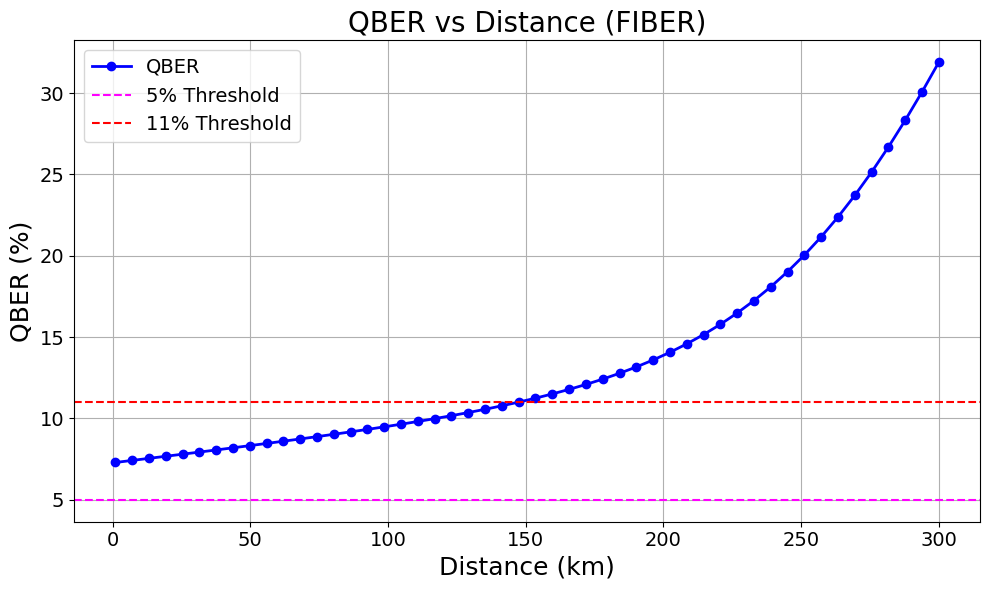

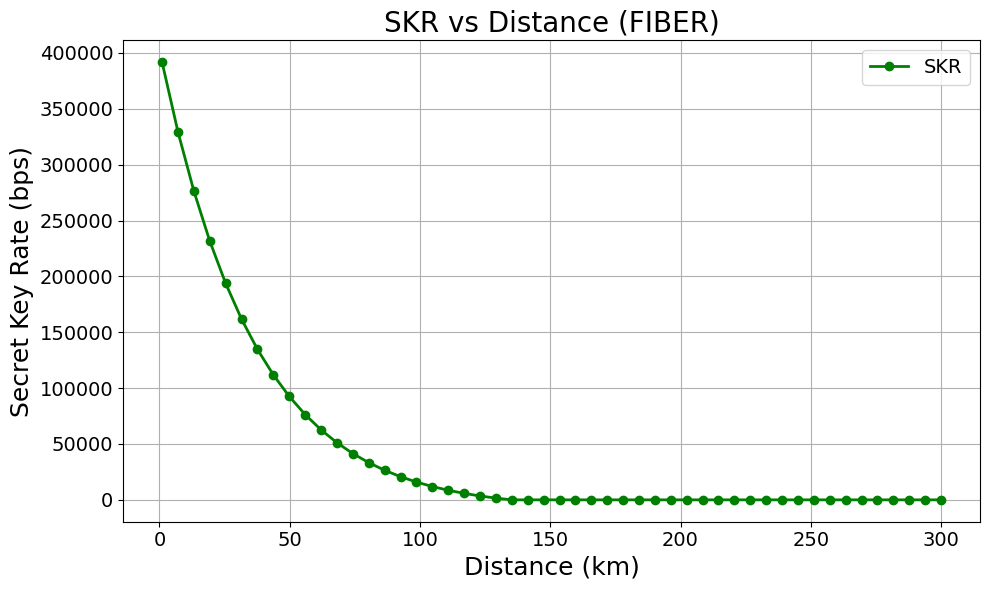

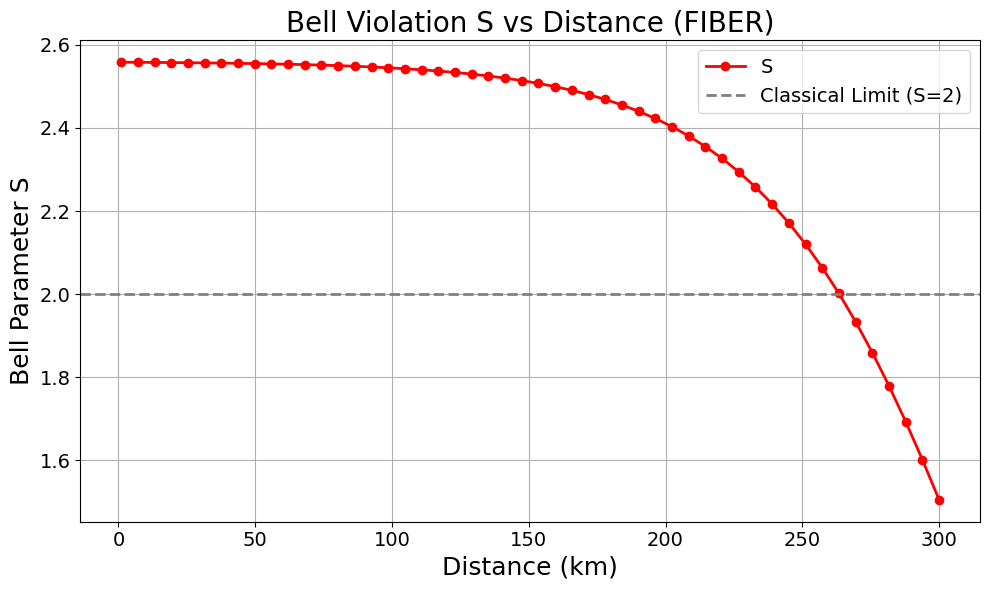

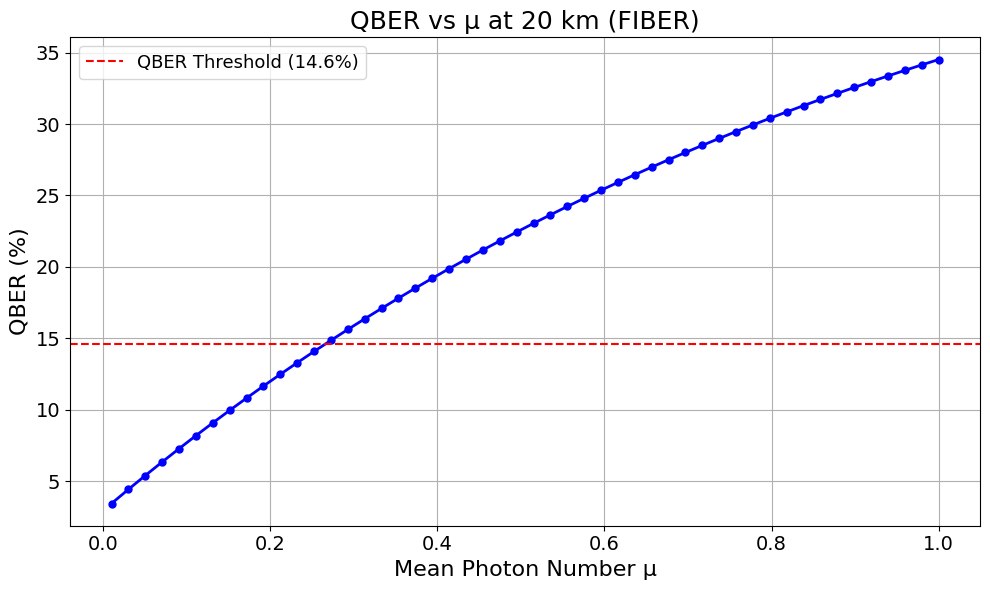

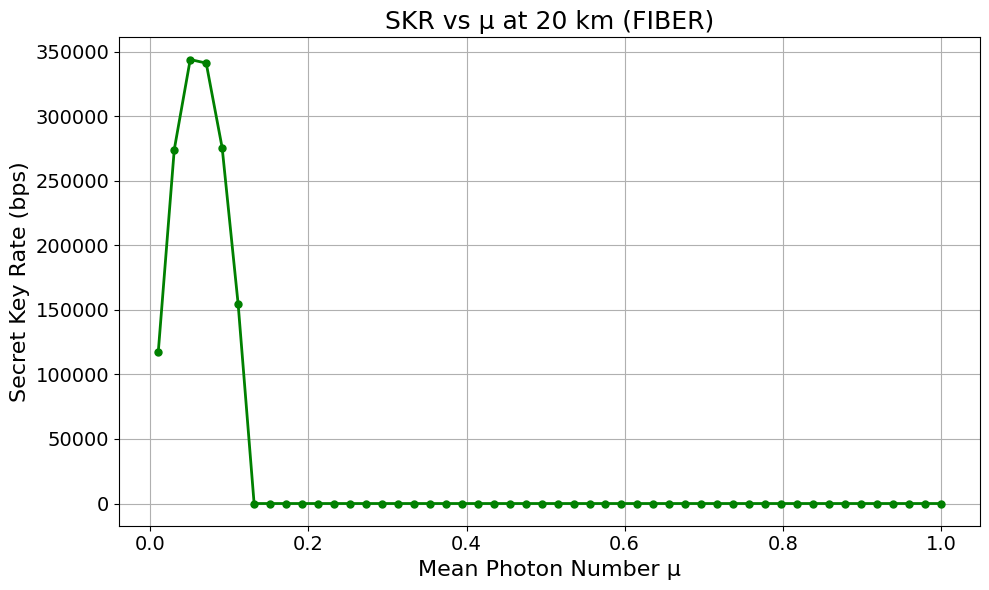

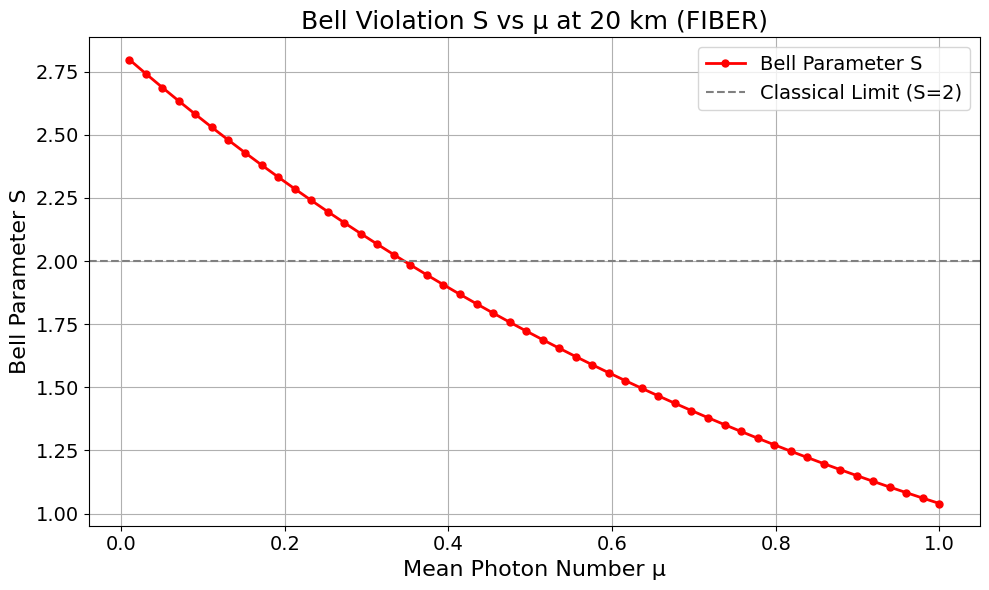

(array([0.01      , 0.03020408, 0.05040816, 0.07061224, 0.09081633,
        0.11102041, 0.13122449, 0.15142857, 0.17163265, 0.19183673,
        0.21204082, 0.2322449 , 0.25244898, 0.27265306, 0.29285714,
        0.31306122, 0.33326531, 0.35346939, 0.37367347, 0.39387755,
        0.41408163, 0.43428571, 0.4544898 , 0.47469388, 0.49489796,
        0.51510204, 0.53530612, 0.5555102 , 0.57571429, 0.59591837,
        0.61612245, 0.63632653, 0.65653061, 0.67673469, 0.69693878,
        0.71714286, 0.73734694, 0.75755102, 0.7777551 , 0.79795918,
        0.81816327, 0.83836735, 0.85857143, 0.87877551, 0.89897959,
        0.91918367, 0.93938776, 0.95959184, 0.97979592, 1.        ]),
 [np.float64(2.7981160505438587),
  np.float64(2.742170170550723),
  np.float64(2.687342337036512),
  np.float64(2.6336102340525707),
  np.float64(2.5809519897280944),
  np.float64(2.5293461674803233),
  np.float64(2.478771757400569),
  np.float64(2.4292081678117516),
  np.float64(2.380635216993392),
  np.float64(2.3

In [10]:
plot_qber_vs_distance()
plot_skr_vs_distance()
plot_bell_violation_vs_distance()
plot_qber_vs_mu()
plot_skr_vs_mu()
plot_bell_violation_vs_mu()

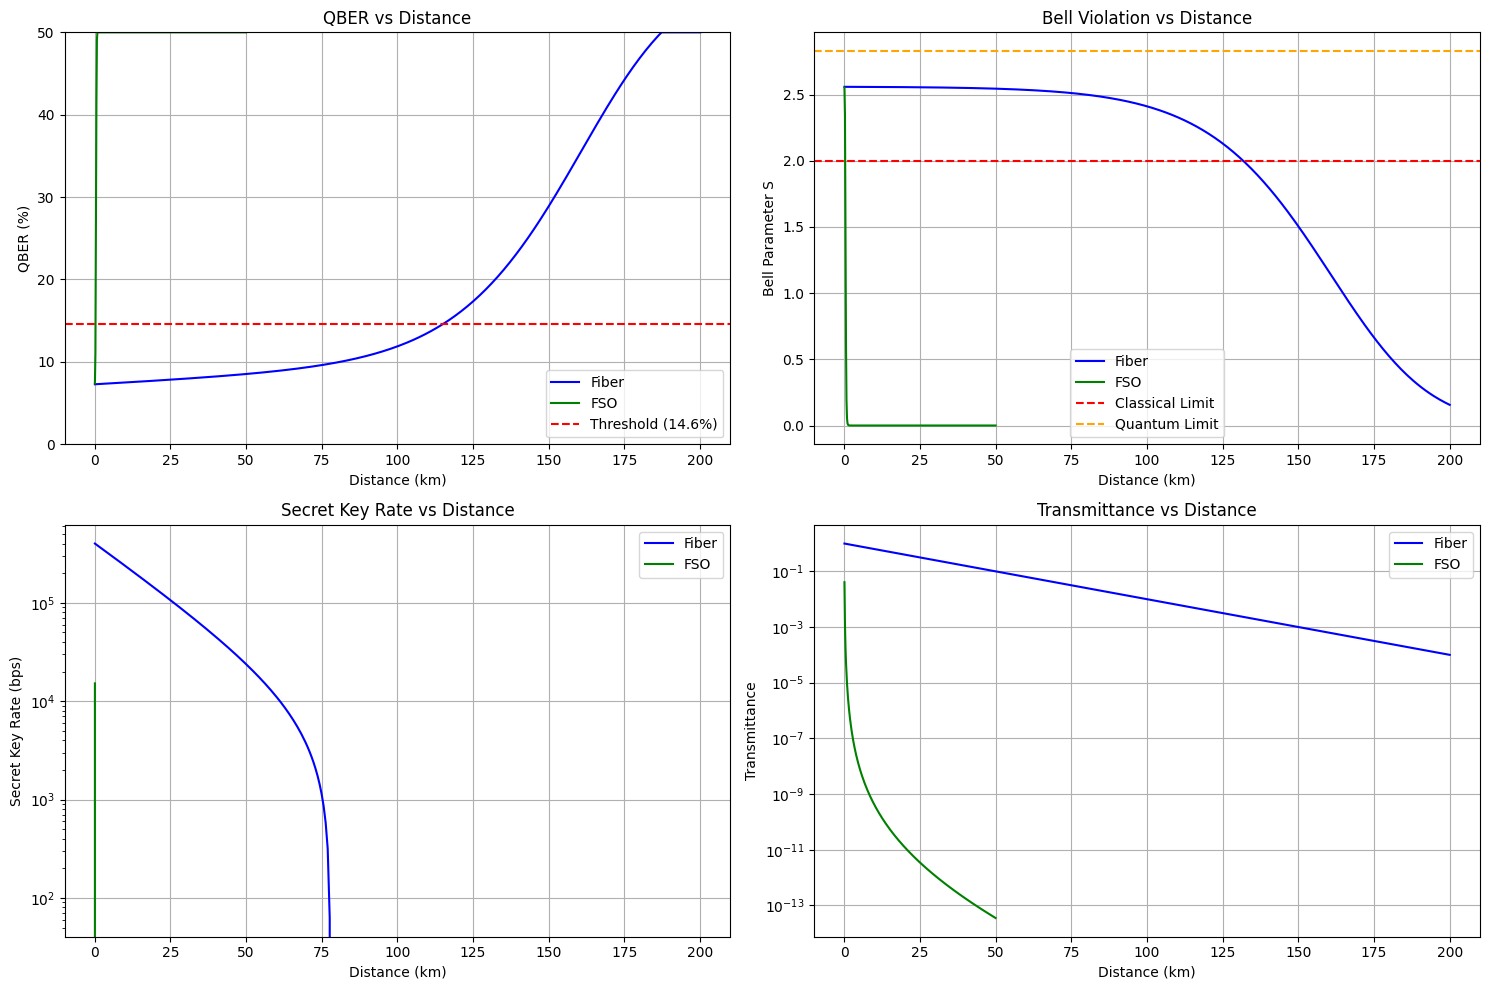

=== E91 QKD Simulation Summary ===

Fiber Channel:
  Max Distance: 200.0 km
  QBER @ Max: 50.00%
  S @ Max: 0.156

FSO Channel:
  Max Distance: 50.0 km
  QBER @ Max: 50.00%
  S @ Max: 0.000

Fiber secure range: up to 115.1 km
FSO secure range: up to 0.3 km


In [11]:
# ========================== E91 QKD Full Comparison Plot ==========================

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# Fiber and FSO channel setup
fiber_channel = QuantumChannel(ChannelType.FIBER)
fso_channel = QuantumChannel(ChannelType.FSO)

# Detector setup (same for both)
detector_fiber = QuantumDetector(0.6, 0.6)  # eta_d, eta_c
detector_fso = QuantumDetector(0.6, 0.6)

# SPDC parameters
mu = 0.1        # Mean photon number per pulse
f_rep = 80e6    # Pulse repetition rate

# Simulator instances
fiber_simulator = E91Simulator(fiber_channel, detector_fiber, distance_km=200, mu=mu, f_rep=f_rep)
fso_simulator = E91Simulator(fso_channel, detector_fso, distance_km=50, mu=mu, f_rep=f_rep)

# Update FSO-specific channel parameters
fso_channel.update_parameters(
    rx_aperture=0.1,
    tx_aperture=0.01,
    beam_divergence=1e-6,
    alpha_db=0.1 * 4.343  # Convert attenuation (dB/km)
)

# Simulate over distance range
fiber_results = fiber_simulator.simulate_distance_range(min_distance=0.1, max_distance=200, num_points=300)
fso_results = fso_simulator.simulate_distance_range(min_distance=0.1, max_distance=50, num_points=300)

# --------------------- Plotting ---------------------
plt.figure(figsize=(15, 10))

# QBER vs Distance
plt.subplot(2, 2, 1)
plt.plot(fiber_results['distances'], fiber_results['qber_percents'], label='Fiber', color='blue')
plt.plot(fso_results['distances'], fso_results['qber_percents'], label='FSO', color='green')
plt.axhline(y=14.6, color='red', linestyle='--', label='Threshold (14.6%)')
plt.xlabel("Distance (km)")
plt.ylabel("QBER (%)")
plt.title("QBER vs Distance")
plt.legend()
plt.grid(True)
plt.ylim(0, 50)

# Bell Parameter vs Distance
plt.subplot(2, 2, 2)
plt.plot(fiber_results['distances'], fiber_results['bell_parameters'], label='Fiber', color='blue')
plt.plot(fso_results['distances'], fso_results['bell_parameters'], label='FSO', color='green')
plt.axhline(2, color='red', linestyle='--', label='Classical Limit')
plt.axhline(2*sqrt(2), color='orange', linestyle='--', label='Quantum Limit')
plt.xlabel("Distance (km)")
plt.ylabel("Bell Parameter S")
plt.title("Bell Violation vs Distance")
plt.legend()
plt.grid(True)

# SKR vs Distance (log scale)
plt.subplot(2, 2, 3)
plt.semilogy(fiber_results['distances'], fiber_results['secret_key_rates'], label='Fiber', color='blue')
plt.semilogy(fso_results['distances'], fso_results['secret_key_rates'], label='FSO', color='green')
plt.xlabel("Distance (km)")
plt.ylabel("Secret Key Rate (bps)")
plt.title("Secret Key Rate vs Distance")
plt.legend()
plt.grid(True)

# Transmittance vs Distance (log scale)
plt.subplot(2, 2, 4)
plt.semilogy(fiber_results['distances'], fiber_results['transmittances'], label='Fiber', color='blue')
plt.semilogy(fso_results['distances'], fso_results['transmittances'], label='FSO', color='green')
plt.xlabel("Distance (km)")
plt.ylabel("Transmittance")
plt.title("Transmittance vs Distance")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --------------------- Summary Output ---------------------
print("=== E91 QKD Simulation Summary ===")
print("\nFiber Channel:")
print(f"  Max Distance: {fiber_results['distances'][-1]:.1f} km")
print(f"  QBER @ Max: {fiber_results['qber_percents'][-1]:.2f}%")
print(f"  S @ Max: {fiber_results['bell_parameters'][-1]:.3f}")

print("\nFSO Channel:")
print(f"  Max Distance: {fso_results['distances'][-1]:.1f} km")
print(f"  QBER @ Max: {fso_results['qber_percents'][-1]:.2f}%")
print(f"  S @ Max: {fso_results['bell_parameters'][-1]:.3f}")

fiber_secure = fiber_results['distances'][fiber_results['secure_regions']]
fso_secure = fso_results['distances'][fso_results['secure_regions']]

if len(fiber_secure) > 0:
    print(f"\nFiber secure range: up to {fiber_secure[-1]:.1f} km")
else:
    print("\nFiber: No secure communication possible")

if len(fso_secure) > 0:
    print(f"FSO secure range: up to {fso_secure[-1]:.1f} km")
else:
    print("FSO: No secure communication possible")
